# Praca domowa z ML numer 6

<a href="https://colab.research.google.com/github/tomczj/ML24_25/blob/main/Tree_Methods/homework_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Oznaczenia:
$R_m(X_j, t)$ <- region powstały po podzieleniu aktualnego liścia względem cechy $X_j$ przy poziomie $t$ (nowe liście)\
$\bar{y}_{R_m}$ <- średnia wartość zmiennej wynikowej w regionie $R_m$\
$T$ <- aktualne drzewo\
$T(X_j, t)$ <- drzewo, które powstało z T po dodaniu dwóch nowych liści $R_1(X_j, t)$, $R_2(X_j, t)$\
$\mathrm{Leaves}(T(X_j, t))$ <- zbiór wszystkich możliwych liści w drzewie $T(X_j, t)$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
import networkx as nx

# Słowem wstępu...

Celem tej pracy domowej jest opisanie wybranych podejść do wyznaczania cech i ich poziomów rozdzielenia przy budowaniu drzewa decyzyjnego. Będziemy chcieli sprawdzić trzy metody:

1. **Lokalna minimalizacja**  
   błędu kwadratowego dla różnych wartości $t$ oraz różnych cech $X_j$. Innymi słowy, w kolejnych krokach budowania drzewa będziemy chcieli znaleźć taką parę $(X_j^*, t^*)$, aby przy podziale kolejnych liści zachodziło
   $$
   (X_j^*, t^*) = \arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2.
   $$
   Takie podejście stosujemy dla każdego kolejnego liścia, co oznacza, że (jak sama nazwa wskazuje) jest to metoda lokalna – w danym momencie analizujemy tylko jednego rodzica i dwa nowe liście.

2. **Maksymalizacja przyrostu**  
   błędu kwadratowego również stanowi metodę lokalną, której idea polega na wybraniu pary $(X_j^*, t^*)$ tak, aby zmaksymalizować przyrost błędu po dodaniu nowych liści. Innymi słowy, wyznaczamy
   $$
   (X_j^*, t^*) = \arg\max_{X_j, t} \Bigl\{
   \underbrace{\sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2}_{\text{Błąd średniokwadratowy u rodzica}}
   \;-\;
   \underbrace{\sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2}_{\text{Błąd średniokwadratowy w nowych liściach}}
   \Bigr\}
   $$
   po dodaniu do aktualnego liścia dwóch nowych.

3. **Minimalizacja całości**  
   błędu kwadratowego. Jest to podejście bardziej złożone i – w przeciwieństwie do dwóch poprzednich – **nie jest metodą lokalną w sensie ścisłym** (choć w pewnym ograniczonym sensie można ją tak traktować). W danym momencie patrzymy na jeden wybrany liść drzewa $T$ i dzielimy go na dwa regiony $R_1(X_j, t)$ oraz $R_2(X_j, t)$. Następnie analizujemy, jak wygląda błąd kwadratowy w całym drzewie $T(X_j, t)$, ale w podziale na poszczególne regiony. Innymi słowy, szukamy
   $$
   (X_j^*, t^*) = \arg\min_{(X_j, t)} \sum_{m \in \mathrm{Leaves}(T(X_j, t))} \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2.
   $$




# Równoważność poszczególnych podejść

Można się zastanowić, czy pomiędzy powyższymi podejściami istnieją równoważności. Innymi słowy: czy różne metody prowadzą do tych samych wyników? W szczególności – zgodnie z treścią zadania – przyjrzymy się, czy **metoda 1** prowadzi do takich samych wyników, co **metoda 2**.

Wystarczy zestawić matematyczne formuły. W metodzie 1 jesteśmy w danym liściu, dzielimy go na dwa względem cech i progów, i szukamy pary $(X_j, t)$, która minimalizuje błąd kwadratowy:

$$
   (X_j^*, t^*) = \arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2.
$$

Korzystając z poniższych przekształceń (pierwsza suma jest stała z perspektywy aktualnie dzielonego liścia), mamy:

\begin{align*}
\max_{X_j, t} \Bigl\{
   \sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2
   \;-\;
   \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2 
   \Bigr\} &= \sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2
   \;+\ \max_{X_j, t} \Bigl\{ -
   \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2 
   \Bigr\}\\
    &= \sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2
   \;-\ \min_{X_j, t} \Bigl\{
   \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2 
   \Bigr\}.
\end{align*}

Wobec tego:

$$
\arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2 = \arg\max_{X_j, t} \Bigl\{
   \sum_{i : x_i \in \text{Rodzic}} (y_i - \bar{y})^2
   \;-\;
   \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2
   \Bigr\},
$$

czyli **podejście 1 jest równoważne podejściu 2**.


# A jak to wygląda w przypadku metody numer 3?

Przyglądając się metodzie numer 3 można zbudować przeświadczenie, że nie prowadzi ona do uzyskania tych samych podziałów co w przypadku wcześniejszych metod. Okazuje się jednak, że jest ona równoważna metodzie 1 (a stąd i metodzie 2). Istotnie, w danym momencie patrzymy na jeden ustalony liść i dzielimy go na dwa, pozostałych nie ruszamy, więc możemy je potraktować jako stałe. Bez straty ogólności załóżmy, że jesteśmy w pierwszym liściu ($m_1$) i po podziale go na dwa dostajemy nowe regiony $R_1(X_j, t)$ oraz $R_2(X_j, t)$. Wówczas, ponownie korzystając z tego, że z perpspektywy pierwszego liścia pozostałe błędy kwadratowe możemy traktować jako stałe

\begin{align*}
\min_{X_j, t} \sum_{m \in \mathrm{Leaves}(T(X_j, t))} \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2 &= \min_{X_j, t} \Big\{\sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2 + \sum_{m \in \mathrm{Leaves}(T)\backslash{m_1}} \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2 \Big\}\\
 &= \min_{X_j, t} \Big\{\sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2\Big\} + \sum_{m \in \mathrm{Leaves}(T)\backslash{m_1}} \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2. 
\end{align*}
Stąd w szczególności
$$
\arg\min_{X_j, t} \sum_{m \in \mathrm{Leaves}(T(X_j, t))} \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2 = \arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2.
$$

Podsumowując możemy zauważyć, że wszystkie opisane wcześniej metody prowadzą do tego samego. Warto jednak zauważyć, że metoda 1 jest najlepsza z obliczeniowego punktu widzenia (mniej liczenia).

Prześledziliśmy jak wyglądają poszczególne metody i pokazaliśmy ich równoważność. Spróbujemy teraz zobaczyć, która metoda została zaimplementowana (domyślnie) w pakiecie `scikit-learn` w `DecisionTreeRegressor`.

# Kod

W tej części pracy skupimy się na przeprowadzeniu doświadczenia. Wygenereujemy zbiór danych a następnie ręcznie zastosujemy wszystkie trzy powyższe metody, aby określić która jest domyślnie wbudowana we wcześniej wspomniany pakiet. Ponadto, oszacujemy te metody na dwóch różnych zbiorach danych - jednym z jedną cechą oraz drugim, który ma 3 cechy. Ponadto, dla zbioru o 3 cechach oszacujemy drzewa głębokości 3, aby dokładniej przeanalizować czy metody się pokrywają.

Poniżej zostały napisane funckje, które mają pomóc zwizualizować drzewo, więc pozostawie je bez większego opisu. Jest to odpowiednik plot_tree.

In [2]:
def create_decision_tree_graph(features_per_level, thresholds_per_level, errors_per_level):
    """
    Tworzy skierowany graf drzewa decyzyjnego z wykorzystaniem biblioteki NetworkX.
    Węzły reprezentują rozgałęzienia i liście drzewa, zawierając istotne informacje:
    cechę (F), próg (T) oraz błąd (SSR) wyświetlony w notacji wykładniczej.
    """
    G = nx.DiGraph()
    max_depth = len(features_per_level)
    
    def format_node_label(level, index):
        # Jeśli poziom zawiera dane dotyczące podziału, tworzymy etykietę z informacjami.
        if level < max_depth:
            feature = features_per_level[level][index]
            threshold = thresholds_per_level[level][index]
            error = errors_per_level[level][index]
            if feature is not None and threshold is not None:
                error_str = f"{error:.2e}" if error is not None else "N/A"
                label = f"F: {feature}\nT: {threshold:.2f}\nSSR: {error_str}"
            else:
                # Gdy brak podziału traktujemy węzeł jako liść
                error_str = f"{error:.2e}" if error is not None else "N/A"
                label = f"Leaf {index}\nSSR: {error_str}"
        else:
            label = f"Leaf {index}"
        return label

    # Dodajemy węzły do grafu
    for level in range(max_depth):
        for i in range(len(features_per_level[level])):
            node_id = f"L{level}_{i}"
            G.add_node(node_id, label=format_node_label(level, i), level=level)

    # Tworzymy krawędzie drzewa binarnego – dzieci w węźle o indeksie i na poziomie l to węzły o indeksach 2*i i 2*i+1 na poziomie l+1.
    for level in range(max_depth - 1):
        num_nodes = len(features_per_level[level])
        for i in range(num_nodes):
            # Jeżeli węzeł nie został podzielony, traktujemy go jako liść
            if features_per_level[level][i] is None or thresholds_per_level[level][i] is None:
                continue
            parent_id = f"L{level}_{i}"
            left_child = f"L{level+1}_{2*i}"
            right_child = f"L{level+1}_{2*i+1}"
            if level + 1 < len(features_per_level):
                if 2 * i < len(features_per_level[level+1]):
                    G.add_edge(parent_id, left_child)
                if 2 * i + 1 < len(features_per_level[level+1]):
                    G.add_edge(parent_id, right_child)
    return G

def compute_hierarchical_positions(G, root=None, width=1.0, vertical_gap=0.2, vertical_loc=0, xcenter=0.5):
    """
    Oblicza pozycje w hierarchicznym układzie drzewa dla grafu G.
    Jeśli nie podano korzenia, wybiera pierwszy węzeł bez poprzedników.
    """
    if root is None:
        root = [n for n, d in G.in_degree() if d == 0][0]

    def _compute_positions(G, root, width, vertical_gap, vertical_loc, xcenter, pos=None):
        if pos is None:
            pos = {root: (xcenter, vertical_loc)}
        else:
            pos[root] = (xcenter, vertical_loc)
        children = list(G.successors(root))
        if children:
            dx = width / len(children)
            nextx = xcenter - width / 2 - dx / 2
            for child in children:
                nextx += dx
                pos = _compute_positions(G, child, dx, vertical_gap, vertical_loc - vertical_gap, nextx, pos)
        return pos

    return _compute_positions(G, root, width, vertical_gap, vertical_loc, xcenter)

def visualize_decision_tree(features_per_level, thresholds_per_level, errors_per_level):
    """
    Buduje i wizualizuje drzewo decyzyjne korzystając z NetworkX i matplotlib.
    Węzły są rysowane jako kwadraty, a etykiety zawierają informacje o cechach, progach
    oraz błąd SSR w notacji wykładniczej.
    """
    G = create_decision_tree_graph(features_per_level, thresholds_per_level, errors_per_level)
    pos = compute_hierarchical_positions(G)
    
    # Pobieramy etykiety węzłów
    labels = nx.get_node_attributes(G, 'label')
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color="lightblue", node_shape='s',
            node_size=1500, font_size=10, font_weight="bold", arrows=True)
    plt.title("Drzewo decyzyjne")
    plt.axis('off')
    plt.show()

## Generowanie zbioru danych

In [3]:
# wygenerujemy prosty zbiór danych, który wykorzystamy do oszcowania drzew
# zbiór będzie bardzo prosty <- dane będą skłądały się z czterech kolumn "wiek" (średni w gospodarstwie), "dochód" (gospodarstwa), "ilość domownkiów"
# będziemy modelować miesięczne wydatki gospodarstwa bazując na powyższych danych (zdefiniujemy je jako nieliniową funckje powyższych)

#Oczywiście zbiór danych nie jest pełny i brakuje wielu zmiennych do modelowana powyższego zjawiska, ale na potrzeby naszego zadania wystarczy
np.random.seed(439669)
#wielkość zbioru danych <- ilość obserwacji
N = 5000

#głębokość wszytskich drzew
max_depth = 3

#generujemy dane
age = np.random.randint(18, 90, size = N)
income = np.random.uniform(4700, 15000, size = N)
people_in_the_house = np.random.randint(1, 7, size = N)


#target variable
spending = 0.7 * income - 20 * age * people_in_the_house + 1500 * people_in_the_house + np.random.normal(0, 10, size = N)

df = pd.DataFrame({
"Spending": spending, 
"Income": income,
"People": people_in_the_house,
"Age": age
})
print(df.describe())

           Spending        Income       People         Age
count   5000.000000   5000.000000  5000.000000  5000.00000
mean    8327.292864   9775.718310     3.503200    53.67840
std     2709.800215   2964.373600     1.708032    20.69094
min     1749.639386   4700.577575     1.000000    18.00000
25%     6304.781394   7222.118246     2.000000    36.00000
50%     8274.913168   9717.543604     4.000000    54.00000
75%    10170.882323  12322.125573     5.000000    72.00000
max    17167.884347  14998.383470     6.000000    89.00000


Bierzemy też inny zbiór danych - jednowymiarowy, aby móc zwizuawlizować proces liczenia błędów i wyznaczania odpowiednich cech i thresholdów.

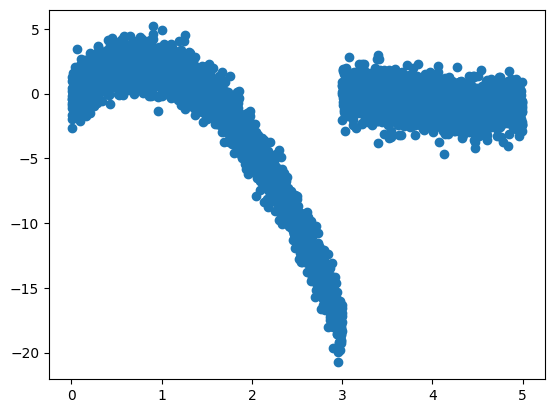

In [4]:
np.random.seed(439669)
X = np.random.uniform(0,5, size = N)

noise = np.random.normal(0, 1, size = N)

#zbiór wybrany raczej for fun w taki sposób
Y = np.array([np.sin(el) if el > 3 else (6 * el - 4 * el**2) for el in X] + noise)

plt.scatter(X, Y)
plt.show()

### Minimalizacja SSR lokalnie (I metoda)

Napisałem poniższe kody w troszkę bardziej zaawanoswanej formie, aby w przyszłości mieć gotowy "customowy" kod do tworzenia drzewa decyzyjnego.

In [5]:
#funkcja do obliczania RSS <- pomyłka w nazwie
def SSR(y):
    if y is None or y.size == 0:
        return 0
    mean = np.mean(y)
    return np.sum((y - mean) ** 2)

# Funkcja wyznaczająca najlepszy podział
def Local_SSR_min(X, y, min_sample_split, add_errors = "False"):
    # Walidacja wejść, przydaje się przede wszytskim gdy fitujemy drzewo, bo wówczas może się pojawić sytuacja, gdy mamy pusty zbiór treningowy
    if X is None or y is None:
        return None, None, None
    if y.size == 0:
        return None, None, None
    
    #definiujemy listę kolumn
    num_of_features = X.shape[1]
    best_feature = None
    best_threshold = None
    best_loss = np.inf

    #przechodzimy przez wszystkie możliwe thresholdy i cechy
    for feature in range(num_of_features):
        unique_values = np.unique(X[:, feature])
        # Jeśli cecha nie ma przynajmniej dwóch unikalnych wartości, podział nie ma sensu
        if unique_values.size < 2:
            continue
        values = np.sort(unique_values)
        
        # Jeśli liczba unikalnych wartości jest mniejsza niż wymagany próg, pomijamy tę cechę
        if values.size < min_sample_split:
            continue

        # Wyznaczamy potencjalne progi jako średnie kolejnych wartości
        thresholds = (values[:-1] + values[1:]) / 2

        #dla ustalonej cechy prtzechodzimy przez wszystkie możliwe thresholdy
        for t in thresholds:
            mask = X[:, feature] <= t
            left_y = y[mask]
            right_y = y[~mask]
            
            # Możemy dodać warunek, by po podziale liczba próbek po stronie była większa lub równa min_sample_split
            if left_y.size < min_sample_split or right_y.size < min_sample_split:
                continue

            left_loss = SSR(left_y)
            right_loss = SSR(right_y)

            total_loss = left_loss + right_loss

            if total_loss < best_loss:
                best_loss = total_loss
                best_threshold = t
                best_feature = feature

    return best_feature, best_threshold, best_loss

# Funkcja tworząca drzewo decyzyjne korzystające z funkcji lokalnego podziału
def fit_tree_SSR_min(X_train, y_train, max_depth, min_sample_split):
    thresholds_per_level = []
    features_per_level = []
    errors_per_level = []
    current_X_sets = [X_train]
    current_y_sets = [y_train]
    
    if max_depth <= 0:
        raise ValueError("max_depth powinno być większe od 0")

    #szukamy kolejnych podziałów i thresholdów dla danej głebokości drzewa
    for depth in range(max_depth):
        next_X_sets = []
        next_y_sets = []
        thresholds_level = []
        error_level = []
        features_level = []

        #nowe zbiory do splitowania
        for X_subset, y_subset in zip(current_X_sets, current_y_sets):
            # Sprawdzamy, czy mamy sensowny podzbiór do dalszego podziału
            if X_subset is None or y_subset is None or X_subset.shape[0] < min_sample_split:
                error_level.append(None)
                next_X_sets.extend([None, None])
                next_y_sets.extend([None, None])
                thresholds_level.append(None)
                features_level.append(None)
                continue

            feature, threshold, err = Local_SSR_min(X_subset, y_subset, min_sample_split)
            # Jeśli nie udało się znaleźć poprawnego podziału, zachowujemy None
            if feature is None or threshold is None:
                error_level.append(None)
                next_X_sets.extend([None, None])
                next_y_sets.extend([None, None])
                thresholds_level.append(None)
                features_level.append(None)
                continue
            
            mask = X_subset[:, feature] <= threshold
            error_level.append(err)
            next_X_sets.extend([X_subset[mask], X_subset[~mask]])
            next_y_sets.extend([y_subset[mask], y_subset[~mask]])
            thresholds_level.append(threshold)
            features_level.append(feature)

        #mamy nowe zbiory do kolejnej pętli, dodajemy thresholdy i cechy
        current_X_sets = next_X_sets
        current_y_sets = next_y_sets
        thresholds_per_level.append(thresholds_level)
        features_per_level.append(features_level)
        errors_per_level.append(error_level)

    return features_per_level, thresholds_per_level, errors_per_level


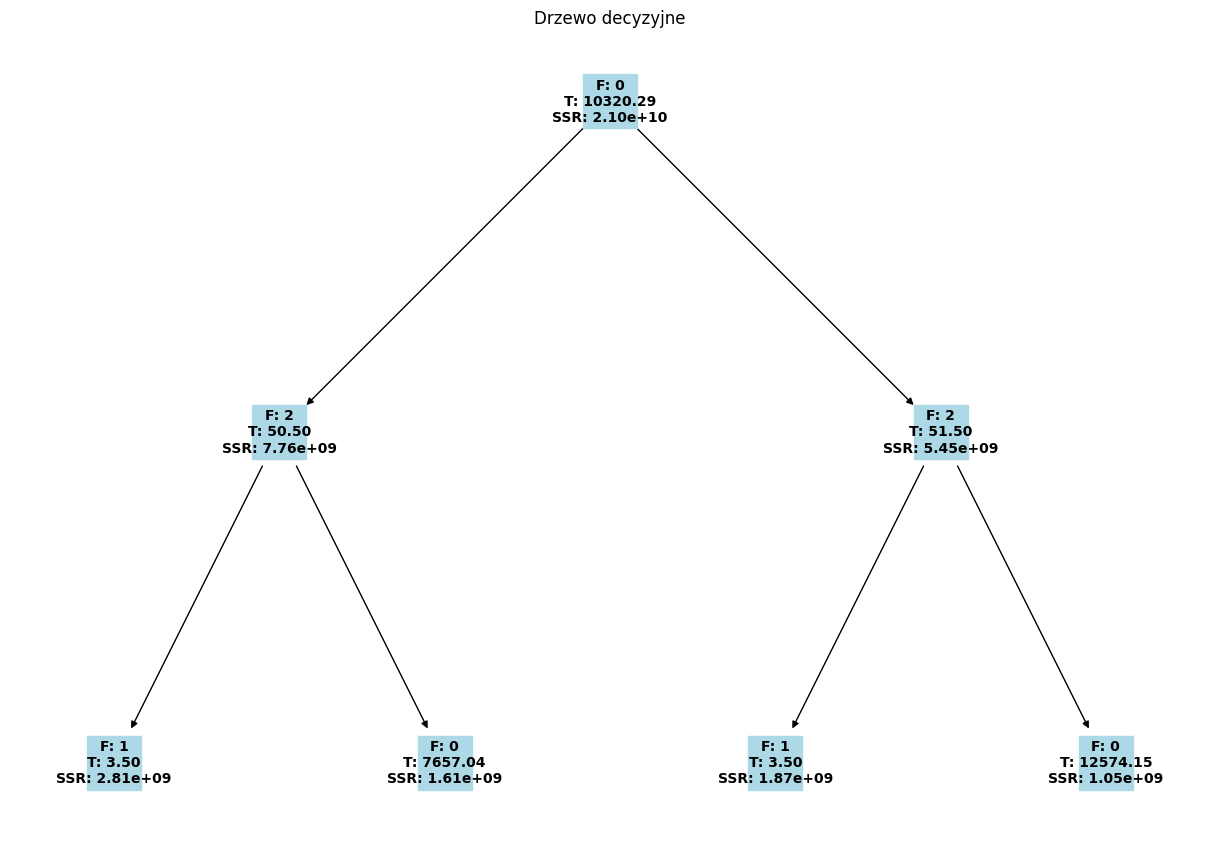

([[0], [2, 2], [1, 0, 1, 0]],
 [[np.float64(10320.28780622099)],
  [np.float64(50.5), np.float64(51.5)],
  [np.float64(3.5),
   np.float64(7657.042038140009),
   np.float64(3.5),
   np.float64(12574.153058634423)]])

In [6]:
# Konwersja danych treningowych do formatu numpy
X_train = df[["Income", "People", "Age"]].to_numpy()
y_train = df["Spending"].to_numpy()

# Dopasowanie drzewa decyzyjnego (przy użyciu funkcji, którą już masz)
features_per_level, thresholds_per_level, errors_per_level = fit_tree_SSR_min(
    X_train, y_train, max_depth, min_sample_split=2
)

# Wizualizacja drzewa decyzyjnego przy użyciu nowych funkcji
visualize_decision_tree(features_per_level, thresholds_per_level, errors_per_level)

#poziomy cech i progów
features_per_level, thresholds_per_level


Poniżej mamy wizualizację błędów i proces wyznaczania optymlanego podziału dla zbioru jednowymiarowego. Jest to dodatkowy kod, aby nie utrudniać procesu plotowania i wcześniejszych funkcji.

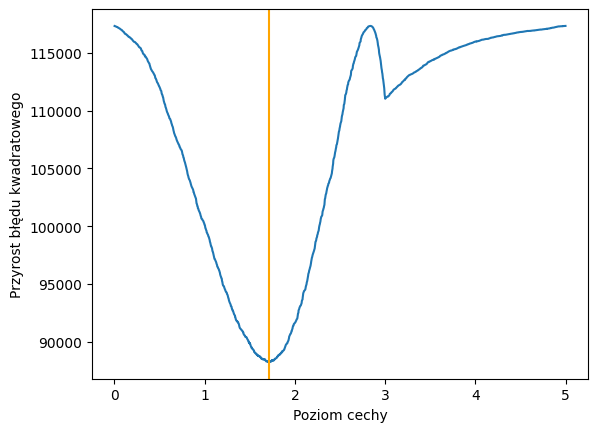

In [7]:
# mamy tylko jedną cechę, więc nie ma tutaj probelmu

#bierzemy unikalne podziały
unique_values = np.sort(np.unique(X))
thresholds = (unique_values[1:] + unique_values[:-1])/2
all_rss = []
best_rss = np.inf
for t in thresholds:
    mask = X <= t

    left_rss = SSR(Y[mask])
    right_rss = SSR(Y[~mask])

    total_rss = right_rss + left_rss
    all_rss.append(total_rss)

    if total_rss < best_rss:
        best_rss = total_rss
        best_threshold = t

plt.plot(thresholds, all_rss)
plt.xlabel("Poziom cechy")
plt.ylabel("Przyrost błędu kwadratowego")
plt.axvline(best_threshold, c = "orange")

### Maksymalizacja przyrostu błędu kwadratowego (II metoda)

In [8]:
def Local_SSR_gain_min(X, y, min_sample_split):
    '''
    Ta funkcja działa na np arrays!
    '''
    # Walidacja wejść
    if X is None or y is None:
        return None, None, None
    if y.size == 0:
        return None, None, None

    num_of_features = X.shape[1]
    best_feature = None
    best_threshold = None
    best_gain =  - np.inf

    for feature in range(num_of_features):
        unique_values = np.unique(X[:, feature])
        # Jeśli cecha nie ma przynajmniej dwóch unikalnych wartości, podział nie ma sensu
        if unique_values.size < 2:
            continue
        values = np.sort(unique_values)
        
        # Jeśli liczba unikalnych wartości jest mniejsza niż wymagany próg, pomijamy tę cechę
        if values.size < min_sample_split:
            continue

        # Wyznaczamy potencjalne progi jako średnie kolejnych wartości
        thresholds = (values[:-1] + values[1:]) / 2

        for t in thresholds:
            mask = X[:, feature] <= t
            left_y = y[mask]
            right_y = y[~mask]
            
            # Możemy dodać warunek, by po podziale liczba próbek po stronie była większa lub równa min_sample_split
            if left_y.size < min_sample_split or right_y.size < min_sample_split:
                continue
            left_loss = SSR(left_y)
            right_loss = SSR(right_y)

            total_ssr = left_loss + right_loss
            all_ssr = SSR(y)
            ssr_gain = all_ssr - total_ssr

            # stosujemy drugą metodę związaną z maksymalizacją przyrostu błędu kwadratowego w danym "liściu", który dzielimy <- metoda II
            if ssr_gain > best_gain:
                best_gain = ssr_gain
                best_threshold = t
                best_feature = feature

    return best_feature, best_threshold, best_gain


#ta funkcja fituje drzewo danej głębokości

def fit_tree_SSR_gain_min(X_train, y_train, max_depth, min_sample_split):
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    thresholds_per_level = []
    features_per_level = []
    errors_per_level = []
    current_X_sets = [X_train]
    current_y_sets = [y_train]

    # przechodzimy przez kolejne warstwy

    for depth in range(max_depth):
        next_X_sets = []
        next_y_sets = []
        thresholds_level = []
        error_level = []
        features_level = []

        # dla poszczególnych zbiorów trenujemy nowe drzewo (mamy inny zbiór) i zapamiętujemy cechy, poziomy oraz błędy
        for X_subset, y_subset in zip(current_X_sets, current_y_sets):
            feature, threshold, err = Local_SSR_gain_min(X_subset, y_subset, min_sample_split)
            mask = X_subset[:, feature] <= threshold

            if feature is None:
                # Powtarzamy dane wejściowe jako "liść"
                thresholds_level.append(None)
                features_level.append(None)
                error_level.append(None)
                next_X_sets.extend([X_subset, X_subset])
                next_y_sets.extend([y_subset, y_subset])
                continue


            error_level.extend([err])
            next_X_sets.extend([X_subset[mask], X_subset[~mask]])
            next_y_sets.extend([y_subset[mask], y_subset[~mask]])
            
            
            thresholds_level.append(threshold)
            features_level.append(feature)

        current_X_sets = next_X_sets
        current_y_sets = next_y_sets
        thresholds_per_level.append(thresholds_level)
        features_per_level.append(features_level)
        errors_per_level.append(error_level)

    return features_per_level, thresholds_per_level, errors_per_level

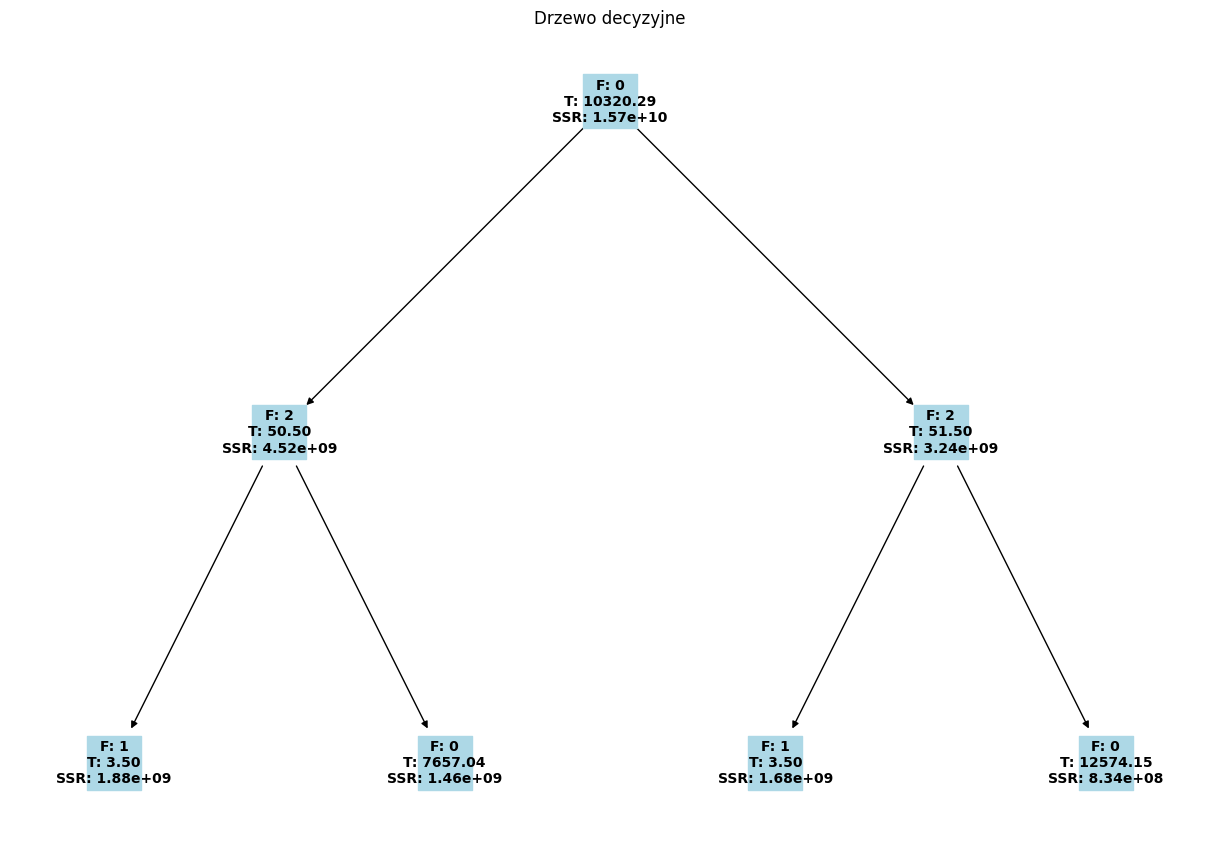

([[0], [2, 2], [1, 0, 1, 0]],
 [[np.float64(10320.28780622099)],
  [np.float64(50.5), np.float64(51.5)],
  [np.float64(3.5),
   np.float64(7657.042038140009),
   np.float64(3.5),
   np.float64(12574.153058634423)]])

In [9]:
# Konwersja danych treningowych do formatu numpy
X_train = df[["Income", "People", "Age"]].to_numpy()
y_train = df["Spending"].to_numpy()

# Dopasowanie drzewa decyzyjnego
features_per_level, thresholds_per_level, errors_per_level = fit_tree_SSR_gain_min(
    X_train, y_train, max_depth, min_sample_split=2
)

# Wizualizacja drzewa decyzyjneg
visualize_decision_tree(features_per_level, thresholds_per_level, errors_per_level)

#Poziomy cechy i progów
features_per_level, thresholds_per_level


Dodatkowo zwizulaizujemy błedy i proces szukania odpowiedniego thresholda i cechy dla okrojonego zbiou danych (1 wymiar) aby pokazać, że rzeczywiście wszystko się zgadza.

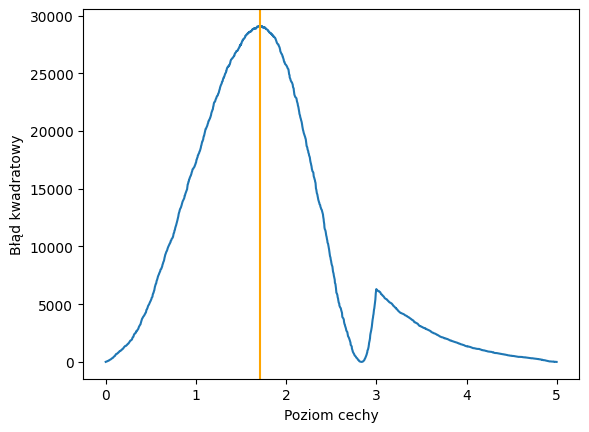

In [10]:
# mamy tylko jedną cechę, więc nie ma tutaj probelmu

#bierzemy unikalne podziały
unique_values = np.sort(np.unique(X))
thresholds = (unique_values[1:] + unique_values[:-1])/2
gain_rss_all = []
best_rss_gain = -np.inf
for t in thresholds:
    mask = X <= t
    parent_RSS = SSR(Y)
    left_rss = SSR(Y[mask])
    right_rss = SSR(Y[~mask])

    total_rss = right_rss + left_rss
    gain_rss = parent_RSS - total_rss
    gain_rss_all.append(gain_rss)

    if gain_rss > best_rss_gain:
        best_rss_gain = gain_rss
        best_threshold = t

plt.plot(thresholds, gain_rss_all)
plt.xlabel("Poziom cechy")
plt.ylabel("Błąd kwadratowy")
plt.axvline(best_threshold, c = "orange")

### Minimalizajca sumarycznego błędu na wszystkich liściach (III metoda)

In [11]:
# Funkcja pomocnicza licząca łączny SSR dla listy liści
def helper_SSR(leaves):
    total_error = 0
    for leaf in leaves:
        if leaf is not None and leaf.size > 0:
            total_error += SSR(leaf)
    return total_error

# Funkcja wyznaczająca najlepszy podział dla podzbioru (X_train, y_train)
# Minimalizuje całkowity SSR na liściach przy dodaniu nowego podziału
def Total_SSR_min(X_train, y_train, leaves):
    """
    Funkcja działa na macierzach NumPy.
    Parametry:
      X_train, y_train - dane wejściowe (np. arrays)
      leaves - lista pozostałych liści, dla których liczymy SSR
    Zwraca:
      best_feature - indeks cechy użytej do podziału
      best_threshold - próg podziału
      best_ssr - łączny SSR po dodaniu nowych liści
    """
    # Weryfikacja wejścia
    if X_train is None or y_train is None or X_train.size == 0 or y_train.size == 0:
        return None, None, np.inf

    # Upewniamy się, że mamy numpy arrays
    num_of_features = X_train.shape[1]
    best_feature = None
    best_threshold = None
    best_ssr = np.inf

    for feature in range(num_of_features):
        # Wyznaczenie uporządkowanych unikalnych wartości dla danej cechy
        values = np.sort(np.unique(X_train[:, feature]))
        # Jeśli cecha nie ma co najmniej dwóch unikalnych wartości, pomijamy ją
        if values.size < 2:
            continue

        # Wyznaczamy potencjalne progi jako średnie kolejnych wartości
        thresholds = (values[:-1] + values[1:]) / 2

        for t in thresholds:
            mask = X_train[:, feature] <= t
            left = y_train[mask]
            right = y_train[~mask]

            # Pomijamy próg, jeśli powoduje pusty podział
            if left.size == 0 or right.size == 0:
                continue

            total_ssr = helper_SSR(leaves + [left, right])

            if total_ssr < best_ssr:
                best_ssr = total_ssr
                best_threshold = t
                best_feature = feature

    return best_feature, best_threshold, best_ssr

# Funkcja budująca drzewo decyzyjne, które stara się minimalizować SSR na wszystkich liściach
def fit_tree_Total_SSR(X_train, y_train, max_depth):
    """
    Buduje drzewo, przy czym każdy poziom drzewa poszukuje podziału, który
    minimalizuje sumaryczny SSR na liściach (tj. wszystkich podziałach aktualnego poziomu).
    Parametry:
      X_train, y_train - dane treningowe (np. arrays)
      max_depth - maksymalna głębokość drzewa
    Zwraca:
      features_per_level - lista funkcji użytych przy podziale na kolejnych poziomach
      thresholds_per_level - lista progów podziałów
      errors_per_level - lista SSR na poziomach
    """
    # Konwersja na numpy arrays

    thresholds_per_level = []
    features_per_level = []
    errors_per_level = []
    current_X_sets = [X_train]
    current_y_sets = [y_train]

    for depth in range(max_depth):
        next_X_sets = []
        next_y_sets = []
        thresholds_level = []
        features_level = []
        error_level = []

        # Na bieżącym poziomie drzewa będziemy przeglądać każdą "łącznie" aktualną próbkę (leaf)
        for i, (X_subset, y_subset) in enumerate(zip(current_X_sets, current_y_sets)):
            # Tworzymy listę pozostałych liści (bez bieżącego)
            other_y_sets = [y for j, y in enumerate(current_y_sets) if j != i]

            # Pomijamy puste podzbiory
            if X_subset is None or X_subset.size == 0 or y_subset is None or y_subset.size == 0:
                thresholds_level.append(None)
                features_level.append(None)
                error_level.append(None)
                next_X_sets.extend([None, None])
                next_y_sets.extend([None, None])
                continue

            feature, threshold, err = Total_SSR_min(X_subset, y_subset, other_y_sets)

            # Jeśli nie znaleziono poprawnego podziału, zachowujemy bieżący liść bez zmian
            if feature is None or threshold is None:
                thresholds_level.append(None)
                features_level.append(None)
                error_level.append(None)
                next_X_sets.extend([None, None])
                next_y_sets.extend([None, None])
                continue

            # Ustalamy podział na podstawie wybranej cechy i progu
            mask = X_subset[:, feature] <= threshold
            left_X = X_subset[mask]
            left_y = y_subset[mask]
            right_X = X_subset[~mask]
            right_y = y_subset[~mask]

            thresholds_level.append(threshold)
            features_level.append(feature)
            error_level.append(err)

            next_X_sets.extend([left_X, right_X])
            next_y_sets.extend([left_y, right_y])

        current_X_sets = next_X_sets
        current_y_sets = next_y_sets
        thresholds_per_level.append(thresholds_level)
        features_per_level.append(features_level)
        errors_per_level.append(error_level)

    return features_per_level, thresholds_per_level, errors_per_level

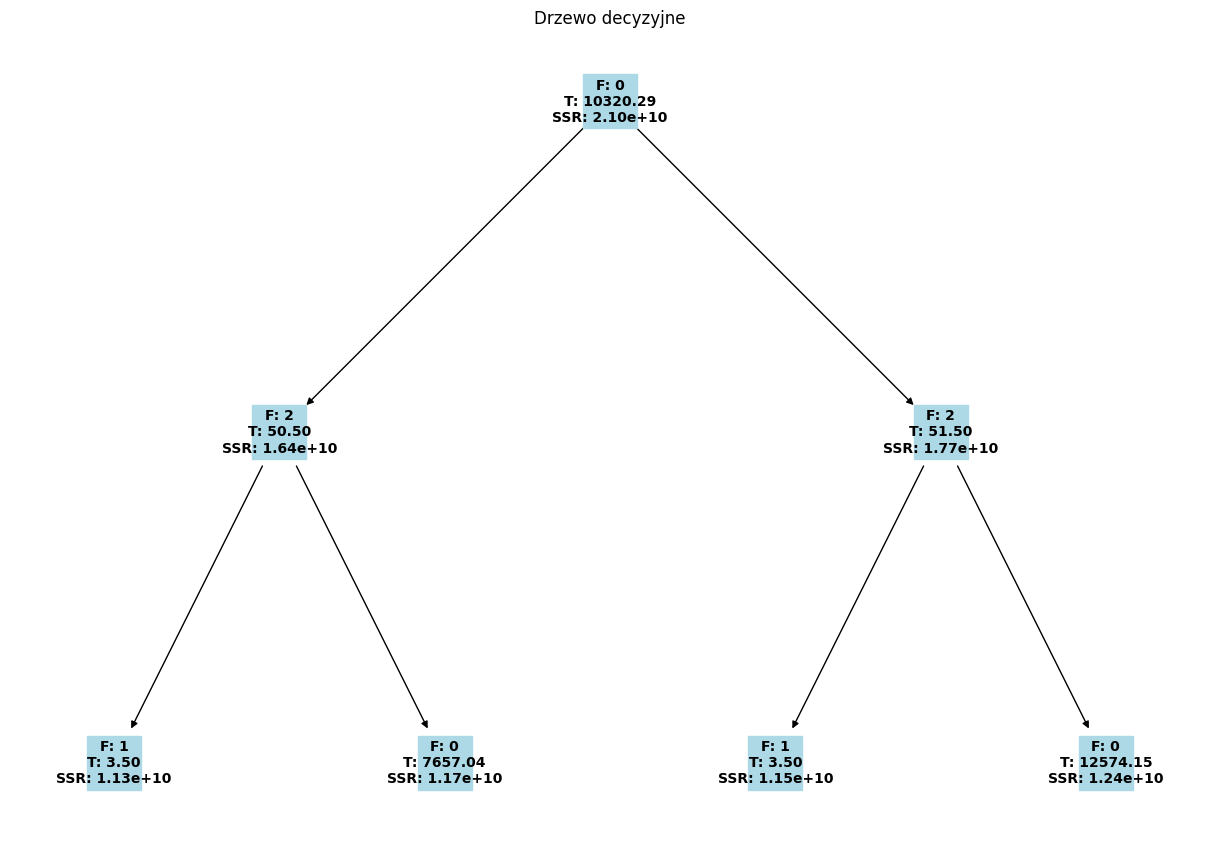

([[0], [2, 2], [1, 0, 1, 0]],
 [[np.float64(10320.28780622099)],
  [np.float64(50.5), np.float64(51.5)],
  [np.float64(3.5),
   np.float64(7657.042038140009),
   np.float64(3.5),
   np.float64(12574.153058634423)]])

In [12]:
# Konwersja danych treningowych do formatu numpy
X_train = df[["Income", "People", "Age"]].to_numpy()
y_train = df["Spending"].to_numpy()

# Dopasowanie drzewa decyzyjnego (przy użyciu funkcji, którą już masz)
features_per_level, thresholds_per_level, errors_per_level = fit_tree_Total_SSR(
    X_train, y_train, max_depth
)

# Wizualizacja drzewa decyzyjnego przy użyciu nowych funkcji
visualize_decision_tree(features_per_level, thresholds_per_level, errors_per_level)

# Dla przykładu, możesz wyświetlić również poziomy cech i progów
features_per_level, thresholds_per_level


## Zastosowanie `DecisionTreeRegressor` w pakiecie `scikit-learn`

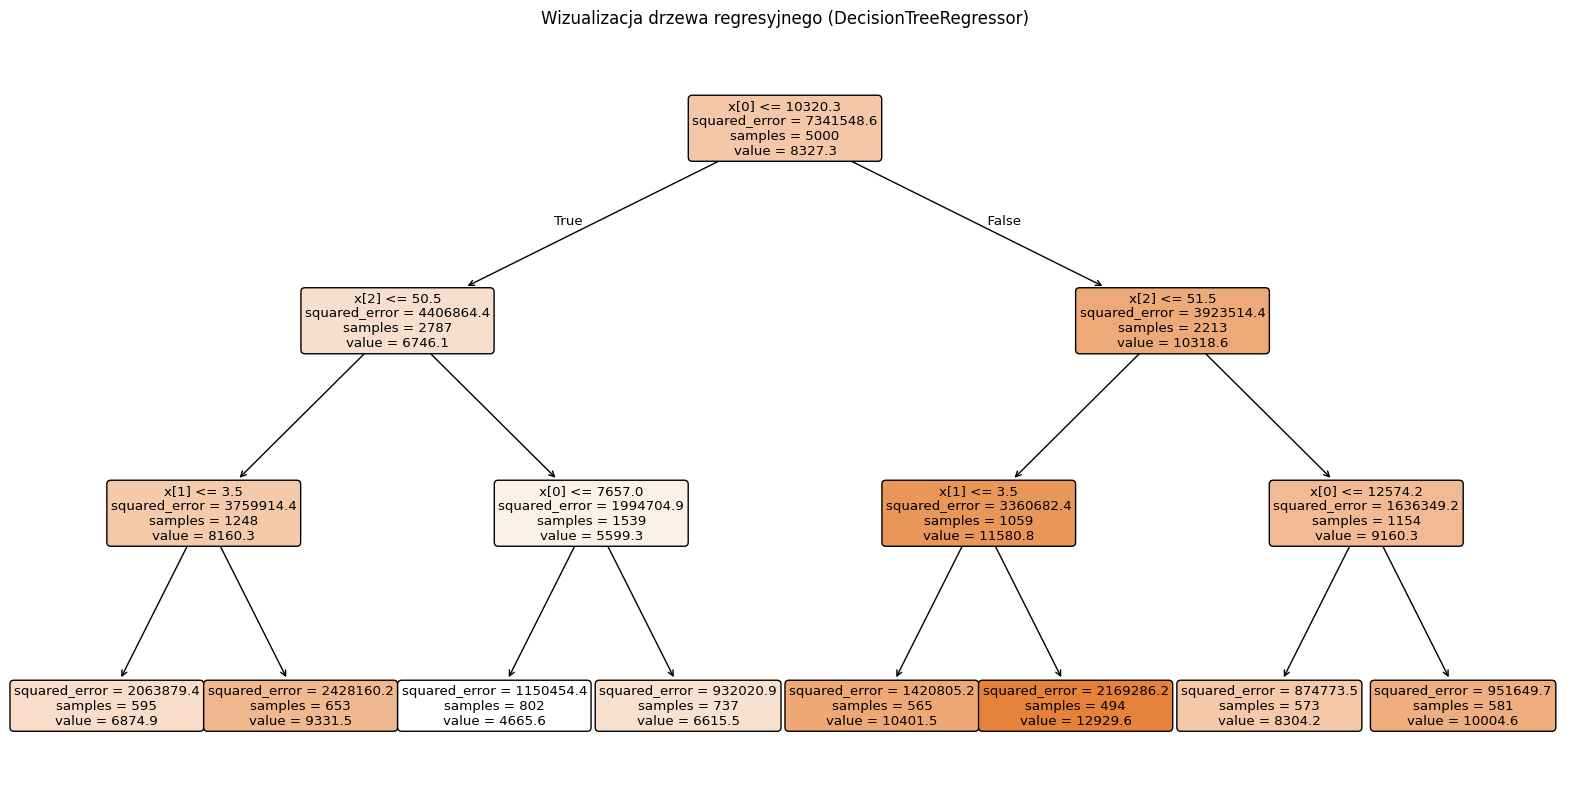

In [13]:
# Trenujemy model
model = DecisionTreeRegressor(max_depth=max_depth)
model.fit(X_train, y_train)

# Tworzymy wizualizację
plt.figure(figsize=(20, 10))
plot_tree(
    model,
    filled=True,
    rounded=True,
    impurity=True,
    precision=1
)
plt.title("Wizualizacja drzewa regresyjnego (DecisionTreeRegressor)")
plt.show()


Dla drzewa jednowymiarowego proces jest taki sam jak w metodzie I, więc pominę to.

## Podsumowanie i odpowiedź na drugie pytanie

Jak zostało udowodnione na początku pliku - wszystkie metody, które zostały tuataj pokazane są sobie równoważne, co ponadto potwierdzają eksperymenty. W każdym z oszacowanych przypadków otrzymano takie same cechy oraz podziały na wszytskich poziomach głębokości drzew decyzyjnych.


 Dodatkowo, uzyskane wyniki pokrywają się z wynikami z `DecisionTreeRegressor` z pakietu `scikit-learn`. Oznacza to, że najprawdopodobniej jedna z powyższych metod została zastosowana do wyliczania błędów (zagłebiając się w dokumentację do optymalizacji drzewa w `scikit-learn` zastosowano "MSE").